In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import randint,uniform,choice

import time

# General Parameters

The SIDHRE-Q Model is as follows:

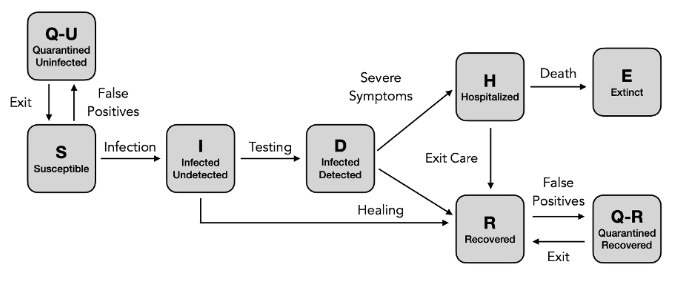


\begin{equation}
\begin{aligned}
\dot{S} &= - \alpha S I  -\eta S D -\gamma S  + \psi Q_U\\
\dot{I} &= + \alpha S I  +\eta S D -(\epsilon + \lambda + \nu) I\\
\dot{D} &= -(\mu + \rho) D  + I (\nu + \epsilon -\mu)\\
\dot{H} &= - (\sigma + \tau) H  + \mu (D + I)\\
\dot{E} &= + \tau H\\
\dot{R} &= -\gamma R + \rho D + \lambda I + \sigma H + \psi Q_R\\
\dot{Q}_U&= -\psi Q_U + \gamma S\\
\dot{Q}_R&= -\psi Q_R + \gamma R\\
\end{aligned}
\end{equation}


In [9]:
n_pop = 1000
n_loc = 261
n_net = 20
n_overlap = 10

# |  L  |  L  |  L  |  L  |  L  |  L  |  L  |  L  | 
# |  N  |  N  |  N  | *N  | *N  |  N  |  -  |  -  | 
# |  -  |  -  |  -  | *H  | *H  |  H  |  H  |  H  |
# ___Only Networks__  (*OVERLAP) _______Homes_________


labels = [0,1,2,3,4,5,6,7] # Number of states a person can be in, [S,I,D,H,E,R,QU,QR] (Not very important, just for bookkeeping)

person_attr = 4  # 4 attributes for a person: state, home, network, current location

### Rates #############

alpha = 0.2
eta   = 0.2
gamma = 0.1
psi   = 0.01
epsilon= 0.1
lam   = 0.2
nu    = 0.1
mu    = 0.1
sigma = 0.2
tau   = 0.1
rho   = 0.1


random_test_rate =1
test_sensitivity =0.3
finish_test_rate =1.0

# Step 1: Create a population

Individuals are defined by `['state', 'home_location', 'network_location', 'current_location' ]`, for example: 

`[0, 0, 4, 0]` is an individual who is susceptible, whose home is `0` and whose work is `4`, and who is currently at home.

In [16]:
def create_person(state, home):                  # Function to create a person with certain attributes
    net = randint(0,n_net)                       # Assign a random network from 0 to n_net (here, 200)
    return np.array([state, home , net , home ]) # Create a person in state 'state', initially at home


pop = np.zeros((n_pop,person_attr),int)          # Empty population
link_weight = np.zeros(n_pop,float)              # Array for link weights
is_confined = np.zeros(n_pop,bool)               # Boolean array, is confined? (Initial values, all "no".)
is_dead     = np.zeros(n_pop,bool)               # Boolean array, is dead? (Initial values, all "no".)
being_tested= np.zeros(n_pop,bool)               # Boolean array, is being tested?

n_per_location=np.zeros((n_loc,len(labels)),int) # Array to hold total number of individuals per state 
                                                 # for all locations: both homes and networks

# Initial populations ###########

n_inf = 10

n_state = np.array([n_pop-n_inf, n_inf, 0, 0, 0, 0,  0, 0  ],int)
                 # [ S         , I,     D, H, E, R, QU, QR ]


output = np.append(0,n_state)  # Output of the form t,[n_state_array]

##################################


for i in range(0,n_pop):
    home = randint(n_overlap-1,n_loc)              # Assign random homes for remainder with random network
    pop[i] = create_person(0,home)

    n_per_location[  pop[i][3] ][0] +=  1          # Increment susceptibles in each person's location

    link_weight[i] = 0.1

r = choice(n_pop,size=n_inf,replace=False)         # Generate n_inf random numbers (r) from the total population without replacement

np.put_along_axis(pop[:,0],r,1,axis=0)             # Set population members at r to infected (1)

i_locs = pop[r][:,3]                               # Find locations of infected individuals (with repetition), eg. [1,2,1,1,3,1,2,3..] etc

np.add.at(n_per_location[:,0],i_locs,-1)           # Decrement number of infected at these locations (repetition increments twice)
np.add.at(n_per_location[:,2],i_locs,+1)           # Increment number of susceptible at these locations (idem)

if(np.sum(n_per_location) != n_pop):
    print("Error: Problem with assigning infected individuals to location. Mismatch in total population number.")


# Step 2: Run Gillespie

In [4]:
def Gillespie_Run(tf,output):
    
    n_state = output[1:]
    
    # [ S, I, D, H, E, R, QU, QR ]
    # [ 0, 1, 2, 3, 4, 5,  6,  7 ]
    t = 0.0
    t_out = 0
    
    while(t<tf):#n_state[1] + n_state[2] >0):   # Until there's no one left to infect anyone (could be t<tf too.)
            
        if(t>=t_out):
            output = np.vstack((output,np.append(t_out,n_state)))
            t_out += 1
            print(t)
        
        
        is_not_conf_or_dead = np.logical_not(is_confined+is_dead)   # Boolean array of people neither confined nor dead 

        a = np.zeros(14,float)
        
#         a1 = alpha*np.sum( n_per_location[:,0] * n_per_location[:,1]) + eta * np.sum( n_per_location[:,0] * n_per_location[:,2])        
#         a2 = a1 + n_exp*e_to_i_rate
#         a3 = a2 + n_inf*recovery_rate
#         a4 = a3 + np.sum(is_not_conf_or_dead)*random_test_rate           # If the rates become person specific, move the product inside the sum
#         a5 = a4 + np.sum(being_tested)*finish_test_rate                  # idem
        
    
        a[0] = gamma*n[0]     # S-> QU
        a[1] = a[0] + psi*n[6]       # QU-> S
        
        a[2] = a[1] + alpha*np.sum(n_per_location[:,0] * n_per_location[:,1]) + eta*np.sum(n_per_location[:,0] * n_per_location[:,2]) # S -> I
        
        a[3] = a[2] + (epsilon + nu)*n[1] # I -> D
        a[4] = a[3] + lam*n[1]
        
        a[5] = a[4] + mu * (n[1] + n[2]) # D -> H
        a[6] = a[5] + rho * n[2]         # D -> R
        
        a[7] = a[6] + tau * n[3]         # H -> E
        a[8] = a[7] + sigma*n[3]         # H -> R
        
        a[9] = a[8] + gamma*n[5]         # R -> QR
        a[10]= a[9] + psi*n[7]           # QR -> R
        
        a[11]= a[10]+ np.sum(is_not_conf_or_dead)*random_test_rate
        a[12]= a[11]+ np.sum(being_tested)*finish_test_rate 
        
        a[13]= a[12]+ np.sum(is_not_conf_or_dead*link_weight)
  
        
        dt = -np.log(uniform(0.0, 1.0)) / a0          # Pick the next time step
        t = t + dt                                    # increment time

        p = uniform(0.0,1.0) * a[13]                     # Choose which process occurs
        
        
        
        
        if(r < a[0]):                                     # In this case, an S-> E
            psum = 0
            
            
            for i in range(0,n_pop):
                if pop[i][0] == 'S':
                    psum += gamma
                    
                    if(psum > r):
                        break
                
            # Set them to be quarantined (undetected), and confined
            pop[i][0] = 'QU'
            is_confined[i] = True
            
            n_sus = n_sus - 1 
            n_qu  = n_qu + 1
            
            n_per_location[pop[i][3]]['S'] -= 1
            n_per_location[pop[i][3]]['QU'] += 1
            
        elif(r < a[1]):
            
            psum = a[0]
            
            for i in range(0, n_pop):
                
                if (pop[i][0] == 'QU'):
                    psum += gamma
                    
                    if(psum>a):
                        break
            
            # Set them to be susceptible and no longer confined
            pop[i][0] = 'S'
            is_confined[i] = False
            
            n_sus = n_sus + 1 
            n_qu  = n_qu - 1
            
            n_per_location[pop[i][3]]['S'] += 1
            n_per_location[pop[i][3]]['QU'] -= 1
        
        elif(r < a[2]):
            psum=a[1]
            
            for i in range(0,n_pop):
                if( pop[i][0] == 'S'):
                    psum += alpha* n_per_location[pop[i]['I'] ] + eta * n_per_location[pop[i]['D'] ]
                    
                    if( psum > r):
                        break
            
            # Set the individual to infected
            pop[i][0] = 'I'
            
            n_sus = n_sus - 1 
            n_inf  = n_inf + 1
            
            n_per_location[pop[i][3]]['S'] -= 1
            n_per_location[pop[i][3]]['I'] += 1
            
            
        elif(r < a[3]):
            psum = a[2]
            
            for i in range(0,n_pop):
                if(pop[i][0] == 'I'):
                    psum += epsilon+nu
                    
                    if(psum>r):
                        break
                        
            
            # Set infected individul to detected (D)
            pop[i][0] = 'D'
            
            n_inf = n_inf - 1 
            n_det  = n_det + 1
            
            n_per_location[pop[i][3]]['I'] -= 1
            n_per_location[pop[i][3]]['D'] += 1
            
        
        elif(r < a[4]):
            psum = a[3]
            
            for i in range(0,n_pop):
                if(pop[i][0] == 'I'):
                    psum += lam
                    
                    if(psum>r):
                        break
                        
            # Set infected to recovered
            pop[i][0] = 'R'
            
            n_inf = n_inf - 1 
            n_rec  = n_rec + 1
            
            n_per_location[pop[i][3]]['I'] -= 1
            n_per_location[pop[i][3]]['R'] += 1
            
        
        elif(r < a[5]):
            psum = a[4]
            
            ###### CHECK IF THIS IS CORRECT: psum is incremented by mu x (D+I)/D. #######
            for i in range(0,n_pop):
                if(pop[i][0] == 'D'):
                    psum += mu*(1 + n_per_location[pop[i][3]]['I']/n_per_location[pop[i][3]]['D'] )
                    
                    if(psum>r):
                        break
            
            # Set detected to hospitalised
            pop[i][0] = 'H'
            
            n_det = n_det - 1 
            n_hos  = n_hos + 1
            
            n_per_location[pop[i][3]]['D'] -= 1
            
            pop[i][3] = 0 ### SEND THEM TO A HOSPITAL (here, location 0)
            is_confined[i] = True
            
            
            n_per_location[pop[i][3]]['H'] += 1
            
            
        elif(r < a[6]):
            psum=a[5]
            
            for i in range(0, n_pop):
                if(pop[i][0]=='D'):
                    psum += rho
                
                    if(psum>r):
                        break
                        
            # Set detected to recovered
            
            pop[i][0] = 'R'
            
            n_det = n_det - 1 
            n_rec  = n_rec + 1
            
            n_per_location[pop[i][3]]['D'] -= 1
            n_per_location[pop[i][3]]['R'] += 1
            
            
        elif(r<a[7]):
            psum=a[6]
            
            for i in range(0,n_pop):
                if(pop[i][0] == 'H'):
                    psum += tau
                
                    if(psum>r):
                        break
                        
            # Set hospitalised to extinct (dead)
            
            pop[i][0] = 'E'
            is_dead[i]= True
            
            n_hos = n_hos - 1 
            n_ext  = n_ext + 1
            
            
            n_per_location[pop[i][3]]['H'] -= 1
            n_per_location[pop[i][3]]['E'] += 1
            
        
        elif(r<a[8]):
            psum = a[7]
            
            for i in range(0,n_pop):
                if(pop[i][0]=='H'):
                    psum += sigma
                    
                    if(psum>r):
                        break
                        
            # Set hospitalised to recovered
            
            pop[i][0] = 'R'
            
            n_hos = n_hos - 1 
            n_rec  = n_rec + 1
            
            n_per_location[pop[i][3]]['H'] -= 1
            
            pop[i][3] = pop[i][1]  # SEND THEM HOME
            
            n_per_location[pop[i][3]]['R'] += 1
        
        
        elif(r<a[9]):
            psum = a[8]
            
            for i in range(0,n_pop):
                
                if(pop[i][0] == 'R'):
                    psum += gamma
                    
                    if(psum>r):
                        break
                        
            # Set recovered to quarantined
            
            pop[i][0] = 'QR'
            is_confined[i]= True
            
            n_rec = n_rec - 1 
            n_qr  = n_qr + 1
            
            n_per_location[pop[i][3]]['R'] -= 1
            n_per_location[pop[i][3]]['QR'] += 1
        
        elif(r<a[10]):
            psum = a[9]
            
            for i in range(0,n_pop):
                
                if(pop[i][0]=='QR'):
                    psum += psi
                    
                    if(psum>r):
                        break
                        
            # Set quarantied back to recovered
            
            pop[i][0] = 'R'
            is_confined[i]= False
            
            n_qr = n_qr - 1 
            n_rec  = n_rec + 1
            
            n_per_location[pop[i][3]]['QR'] -= 1
            n_per_location[pop[i][3]]['R'] += 1
            
            # NOT DOING TESTING HERE ###
            
#         elif(a<a4):                                     # Conduct a random test
#             psum = a3

#             for i in range(0,n_pop):
#                 if(not is_confined[i] and not is_dead[i]):# If the person isn't confined or dead
#                     psum += random_test_rate
#                     if(psum>a):
#                         break

#             being_tested[i]=True

#         elif(a<a5):
#             psum = a4
#             for i in range(0,n_pop):

#                 if being_tested[i] == True:
#                     psum += finish_test_rate

#                     if(psum>a):
#                         break

#             being_tested[i]=False    

#             if (pop[i][0]==2 and uniform(0.0,1.0)<test_sensitivity): # If the person is infected and the test works
#                 is_confined[i] = True                                # They are confined
                
#                 n_per_location[pop[i][3]][2] -= 1          # Decrement infected in current (NET or HOME) location of person
#                 pop[i][3] = pop[i][1]                      # Send them home (set current location to home location)
#                 n_per_location[pop[i][3]][2] += 1          # Increment infected in HOME location of person


        else:                                              # All else failing, move people around
            psum = a[10]
            
            for i in range(0,n_pop):

                if (not is_confined[i] and not is_dead[i]):  # If they aren't confined or dead
                    psum += link_weight[i]                 # move them to their other location

                    if(psum>r):
                        break

            home_loc = pop[i][1]
            net_loc  = pop[i][2]

            if(pop[i][3]==home_loc):                       # If the person is at home
                pop[i][3] = net_loc                        # move them to their network location
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[home_loc][j] -= 1
                        n_per_location[net_loc][j] += 1     
                
            else:
                pop[i][3] = home_loc                       # otherwise move them home
                
                for j in range(0,len(labels)):
                    if(pop[i][0]==j):
                        n_per_location[net_loc][j] -= 1
                        n_per_location[home_loc][j] += 1

    return output


In [ ]:
start = time.time()

to_print_to_file = Gillespie_Run(100,output)

end = time.time()

print("Time elapsed: "+str(end-start))

np.savetxt("sample_8.txt",to_print_to_file,delimiter=" ")

0.0
1.0000665915844438
2.0000793025942123
3.0002602613859657
4.0001453830742575
5.000049775355022
6.00005628142901
7.000035567841698
8.000127478381772
9.000150457690589
10.000070155401975
11.00013259028617
12.000096568713765
13.000119908818457
14.000012994773506
15.000017953633952
16.000001828302654
17.000003448813846
18.000075270022364
19.00002194743153


In [17]:
testarray = np.array([1,2,3,4,5,6,7])
print(testarray[1:])

[2 3 4 5 6 7]
